In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Verify conditional circuit generation

We have previously trained a neural network known as a conditional variational autoencoder on genetic circuits. The conditioning variable was made to be one of the characteristics of the genetic circuit's dynamics, for example the sensitivity of the circuit to a signal. While the distributions for each class of conditional variables differ in the AI-generated circuits, the verification of their ground-truth label is still necessary to assess the validity of the conditionality.

## Imports

In [63]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation

import os
import sys
import numpy as np
import jax
import jax.numpy as jnp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()


[cuda(id=0), cuda(id=1)]

In [64]:
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.scripts.verify import verify
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import vis_sampled_histplot


# Use verify function

In [65]:
# hpos = pd.Series(load_json_as_dict('data/01_cvae/2025_01_21__15_09_53/hpos_all.json'))
 
# fn_saves = os.path.join('weight_saves', '01_cvae',
#                         # '2024_12_19__16_10_53_saves_hs16_ls32_nlayers2_adam')
#                         # 'saves_2025_01_14__16_43_17_prec_sens')
#                         # 'saves_2025_01_14__17_44_21_sens')
#                         # 'saves_2025_01_17__16_01_57_sens_no_cat')
#                         'saves_2025_01_21__22_40_13_no_cat_sens_prec')
# fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__15_33_42_adapt')
# fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__21_26_05_prec_sens') 

dir_src = os.path.join('data', '01_cvae', '2025_01_26__16_44_57')
hpos = pd.Series(load_json_as_dict(os.path.join(dir_src, 'hpos_all.json')))
fn_saves = os.path.join(dir_src, 'saves_2025_01_26__16_44_57_sens_kl_5e4_epochs100')
saves_loaded = load_json_as_dict(fn_saves)
top_write_dir = os.path.join('data', '02_cvae_verify', make_datetime_str())
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

if not os.path.exists(top_write_dir):
    os.makedirs(top_write_dir)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
val_config = config_bio['base_configs_ensemble']['generate_species_templates']
val_config.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])

# Run

In [66]:
hpos['eval_n_to_sample'] = 20000
n_to_sample_per_cat = int(int(hpos['eval_n_to_sample']) / (config_norm_y.categorical_n_bins ** len(config_dataset.objective_col)))

print('Going to sample', n_to_sample_per_cat, 'per category for a total of', int(hpos['eval_n_to_sample']), 'samples')

Going to sample 2000 per category for a total of 20000 samples


In [67]:
data['response_time_wrt_species-6'] = np.where(data['response_time_wrt_species-6'] < np.inf, data['response_time_wrt_species-6'], np.nan)

filt = (data['response_time_wrt_species-6'] < (0.8 * np.nanmax(data['response_time_wrt_species-6']))) & (data['sample_name'] == 'RNA_2')
# sns.histplot(data, x='response_time_wrt_species-6', bins=50)
data[filt].iloc[(np.argmax(np.log10(data[filt]['sensitivity_wrt_species-6'])))]['response_time_wrt_species-6'], np.log10(data[filt]['sensitivity_wrt_species-6']).max(), len(data[filt]), len(data[data['sample_name'] == 'RNA_2'])

(np.float64(263.52704), np.float64(2.4863761213375506), 93047, 200000)

In [68]:
config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal']['simulation']['threshold_steady_states'] = 0.01
config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal']['simulation']['t1'] = 1000

In [69]:
(
    analytics, ys, ts, y0m, y00s, ts0, fake_circuits, reverse_rates, model_brn, qreactions, ordered_species, input_species, z, sampled_cond
) = verify(params=params,
           rng=rng,
           decoder=decoder,
           df=df,
           cond=np.array([-0.1, 1.1]),
           config_bio=val_config,
           config_norm_y=config_norm_y,
           config_dataset=config_dataset,
           config_model=config_model,
           x_datanormaliser=x_datanormaliser,
           x_methods_preprocessing=x_methods_preprocessing,
           y_datanormaliser=y_datanormaliser,
           output_species=config_dataset.output_species,
           signal_species=config_dataset.signal_species,
           input_species=data[data['sample_name'].notna()]['sample_name'].unique(),
           n_to_sample=n_to_sample_per_cat,
           visualise=True,
           top_write_dir=top_write_dir,
           return_relevant=True,
           impose_final_range=(df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].min().min(),
                               df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].max().max()))


Steady states found. Now calculating signal response
data/02_cvae_verify/2025_01_26__17_19_33


In [70]:
# analytics = load_json_as_dict(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'analytics.json'))
# ts = np.load(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'ts.npy'))
# ys = np.load(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'ys.npy'))
# fake_circuits = np.load(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'fake_circuits.npy'))
# y0m = np.load(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'y0m.npy'))

Text(0.5, 0, 'time')

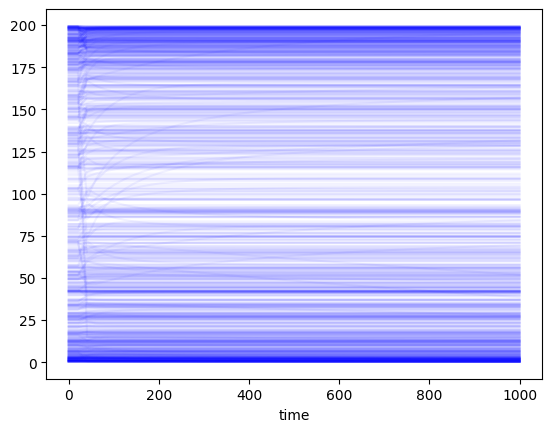

In [71]:
idx_species = -1
plt.plot(np.repeat(ts[None, :], repeats=1000, axis=0).T, ys[:1000, :, idx_species].T, alpha=0.05, color='b')
plt.xlabel('time')

In [72]:
# print(data_writer.top_write_dir)
# data_writer.output(data=analytics, out_type='json', out_name='analytics')
# data_writer.output(data=ys, out_type='npy', out_name='ys')
# data_writer.output(data=ts, out_type='npy', out_name='ts')
# data_writer.output(data=y0m, out_type='npy', out_name='y0m')
# data_writer.output(data=fake_circuits, out_type='npy', out_name='fake_circuits')

In [73]:
for k in analytics.keys():
    analytics[k] = np.array(analytics[k])

In [74]:
idx_species = -1
idx_signal = -3
idx_max = np.argmax(analytics['overshoot'][:, idx_species])


In [75]:
np.nanmax(analytics['sensitivity_wrt_species-6'][:, idx_species])

np.float64(642.2203369140625)

In [76]:
analytics['initial_steady_states'][idx_max, -3]

np.float64(400.0)

(Array([-23.307606 ,  -5.5918946, -13.209448 ,  -3.9701734,  -1.3488908,
         -0.4790082], dtype=float32),
 np.float64(0.5144253373146057))

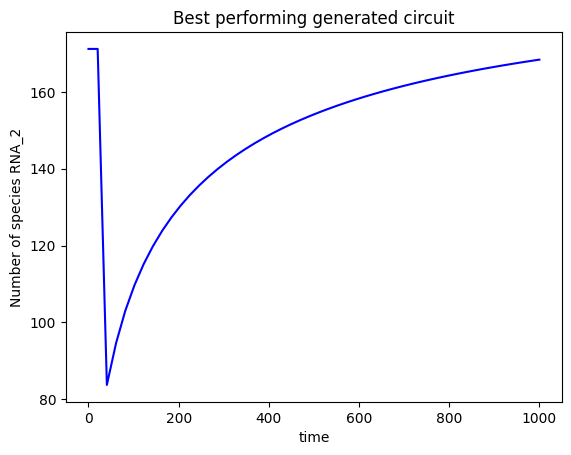

In [77]:
idx_signal = -3
plt.plot(ts, ys[idx_max, :, idx_species].T, color='b')
plt.xlabel('time')
plt.ylabel(f'Number of species {input_species[idx_species]}')
plt.title('Best performing generated circuit')
fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idx_max], analytics['sensitivity_wrt_species-6'][idx_max, idx_species]


# Visualise

In [78]:
category_array = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sampled_cond, config_dataset.objective_col[0]).reshape(np.prod(sampled_cond.shape[:-1]), -1)

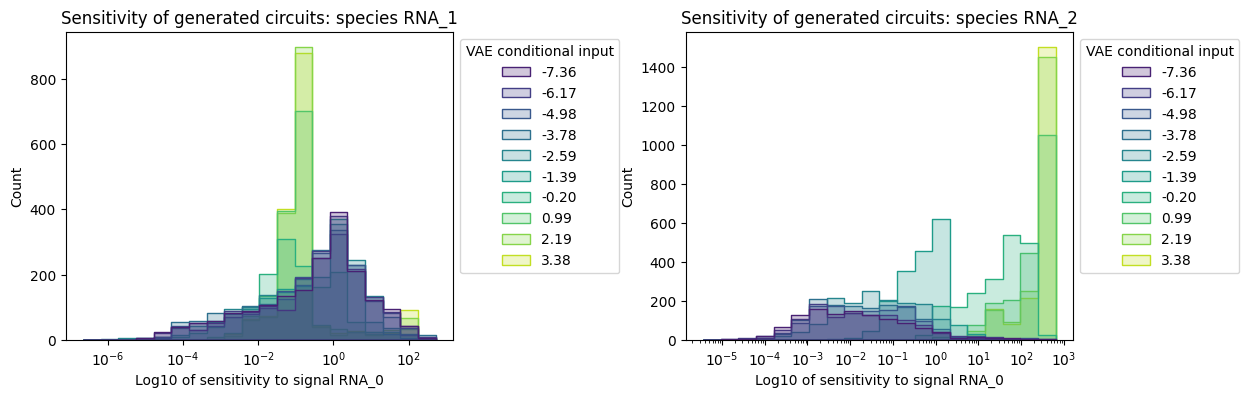

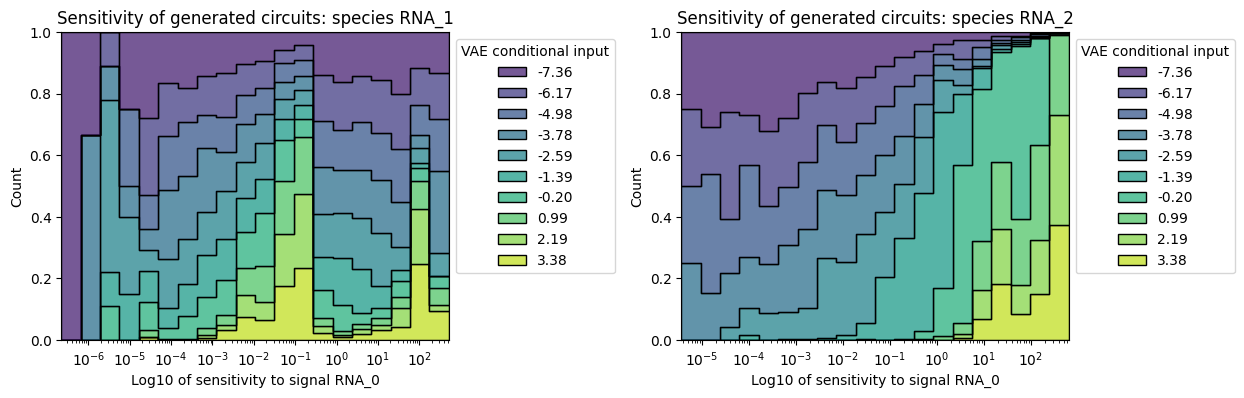

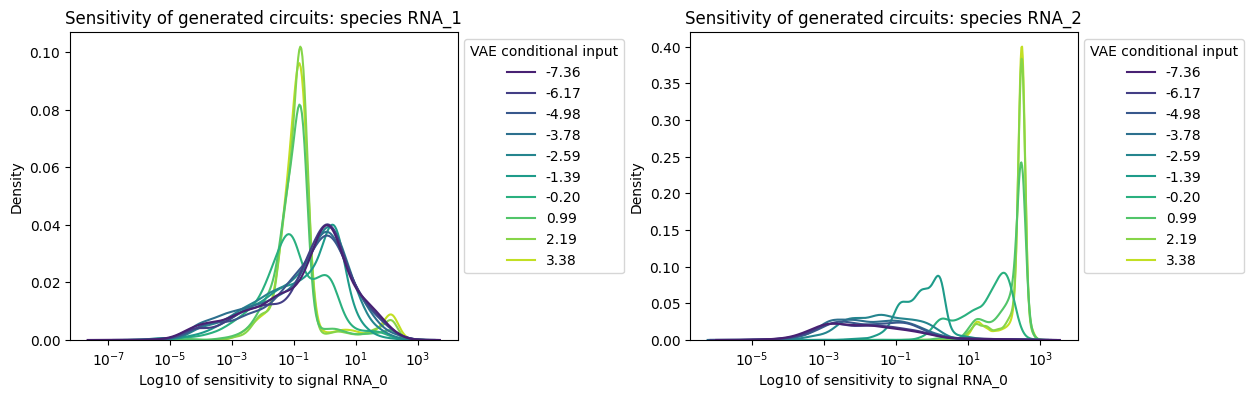

In [79]:
output_species = ['RNA_1', 'RNA_2']

if 'Log sensitivity' not in analytics:
    analytics['Log sensitivity'] = np.log10(analytics['sensitivity_wrt_species-6'])
    analytics['Log precision'] = np.log10(analytics['precision_wrt_species-6'])


vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], model_brn, output_species, category_array, 
                     title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer', show=True)

vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], model_brn, output_species, category_array, 
                     title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='fill', show=True)

vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], model_brn, output_species, category_array, 
                     title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer', show=True,
                     f=sns.kdeplot, log_scale=[True, False], fill=False)

In [80]:
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity_wrt_species-6'], analytics['precision_wrt_species-6'])


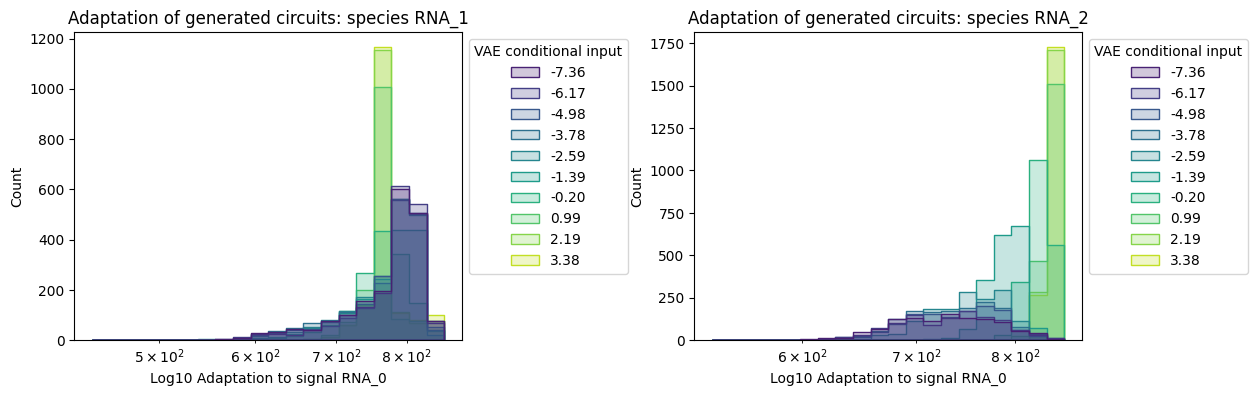

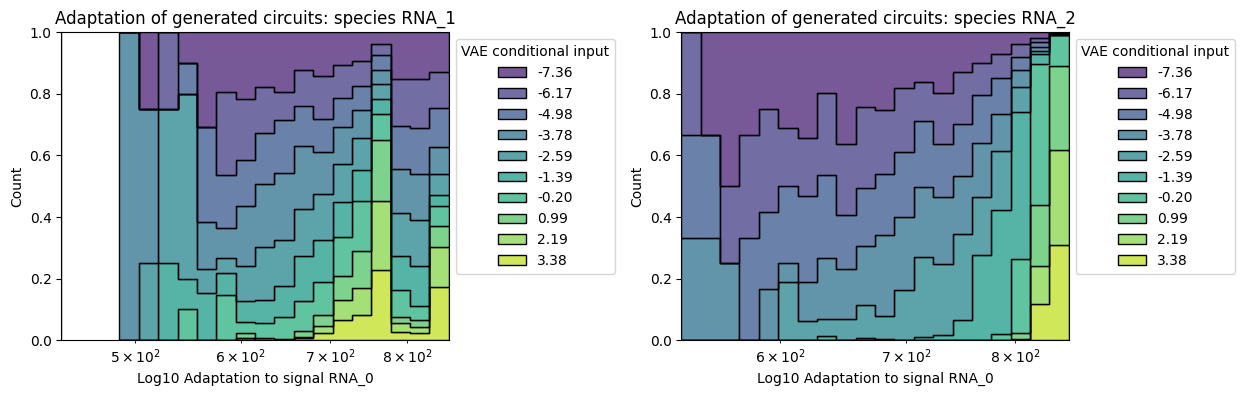

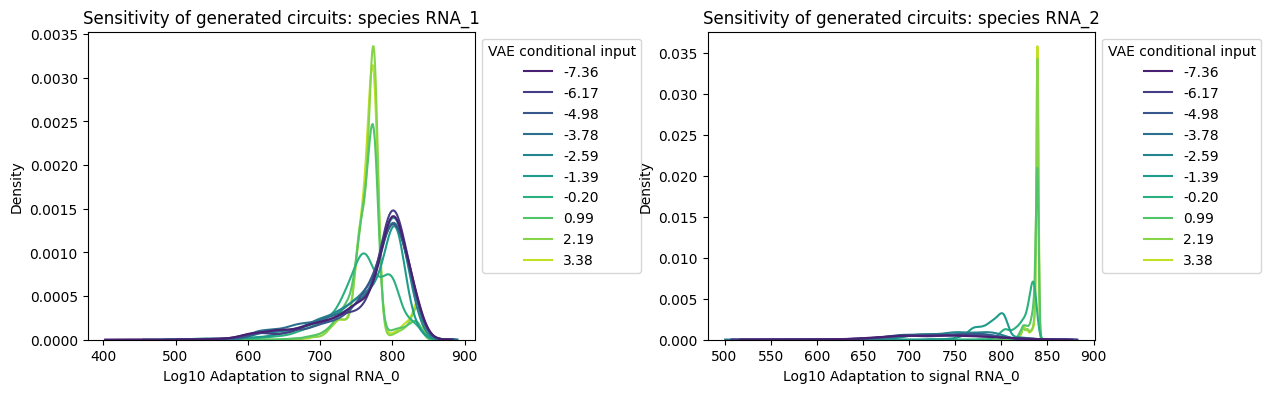

In [81]:
vis_sampled_histplot(analytics['adaptation'], model_brn, output_species, category_array,
                     title=f'Adaptation of generated circuits', x_label=f'Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='layer', show=True)

vis_sampled_histplot(analytics['adaptation'], model_brn, output_species, category_array,
                     title=f'Adaptation of generated circuits', x_label=f'Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='fill', show=True)

vis_sampled_histplot(analytics['adaptation'], model_brn, output_species, category_array,
                     title=f'Sensitivity of generated circuits', x_label=f'Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='layer', show=True,
                     f=sns.kdeplot, log_scale=[False, False], fill=False)

/tmp/ipykernel_1232989/3417901513.py:11: RuntimeWarning: divide by zero encountered in log10
  analytics[f'Log {k.split("_")[0]}'] = np.log10(analytics[k])
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appr

Diffs: [ 7.0621877   5.8779707   4.546693    3.3504355   2.11244     0.42383456
 -1.2428988  -2.1478717  -3.1214943  -4.314955  ] 34.200783
Diffs: [ 4.2047534  3.1050029  2.3799849  1.444746   0.7945142  1.0875281
  1.8348359  1.4279933  0.2917955 -0.9014871] 17.472641


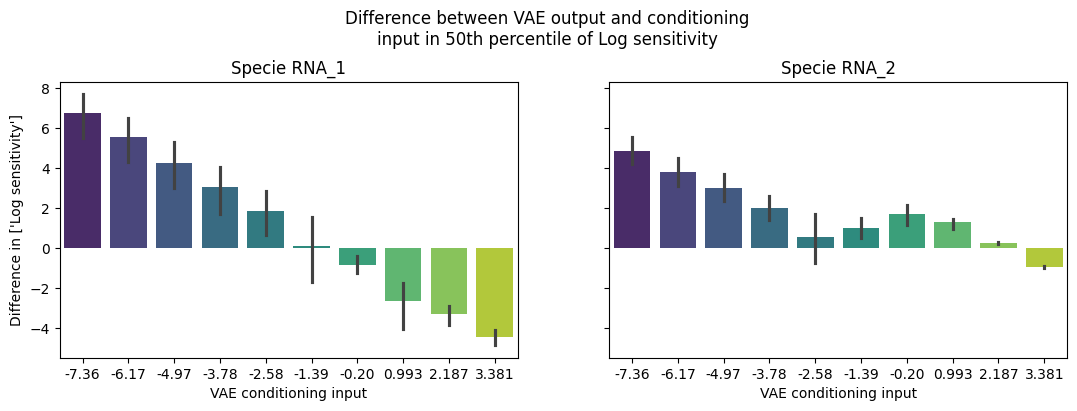

In [82]:
def plot_bar(diffs_conditional_real_sens, sampled_conds, ax, palette='viridis'):
    sns.barplot(pd.DataFrame(diffs_conditional_real_sens.T, columns=[
                str(ii)[:5] for ii in sampled_conds.flatten()]), palette=palette, ax=ax)
    plt.xlabel('VAE conditioning input')
    plt.ylabel(f'Difference in {config_dataset.objective_col}')


for k in ['sensitivity_wrt_species-6', 'precision_wrt_species-6', 'adaptation']:
    analytics[k] = np.where(np.isnan(
        analytics[k]), 0, analytics[k])
    analytics[f'Log {k.split("_")[0]}'] = np.log10(analytics[k])
n_categories = fake_circuits.shape[0]

sampled_conds = np.unique(category_array)
for k in config_dataset.objective_col:
    # sampled_conds = np.array(
    #     sorted(y_datanormaliser.metadata[k]['category_map'].values()))

    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 4))
    fig.subplots_adjust(hspace=0.3, top=0.8)
    for i, output_specie in enumerate(output_species):
        output_idx = [s.name for s in model_brn.species].index(output_specie)
        diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
            analytics[k][:, output_idx].reshape(n_categories, int(hpos['eval_n_to_sample']) // n_categories)) - sampled_conds[:, None]

        plt.axes(axs[i])
        plot_bar(diffs_conditional_real_sens, sampled_conds, axs[i])
        plt.title(f'Specie {output_specie}')
        print('Diffs:', diffs_conditional_real_sens[:, 1], np.sum(
            np.abs(diffs_conditional_real_sens[:, 1])))

    plt.suptitle(
        f'Difference between VAE output and conditioning\ninput in 50th percentile of {k}')

category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


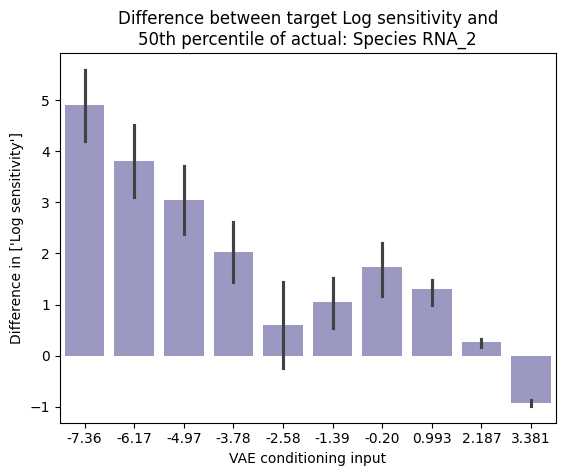

In [83]:
for k in config_dataset.objective_col:
    plt.figure()
    output_idx = [i.name for i in model_brn.species].index(
        config_dataset.output_species[0])
    diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
        analytics[k][:, output_idx].reshape(n_categories, int(hpos['eval_n_to_sample']) // n_categories)) - sampled_conds[:, None]
    plot_bar(diffs_conditional_real_sens, sampled_conds, plt.subplot(1, 1, 1),
            palette=sns.cubehelix_palette(start=3, rot=0, dark=0.6, light=.6, reverse=False, as_cmap=False, n_colors=n_categories))
    #  palette=sns.cubehelix_palette(start=1, rot=1.5, dark=0.3, light=.7, reverse=False, as_cmap=False, n_colors=10))
    plt.title(
        f'Difference between target {k} and\n50th percentile of actual: Species {config_dataset.output_species[0]}')

category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


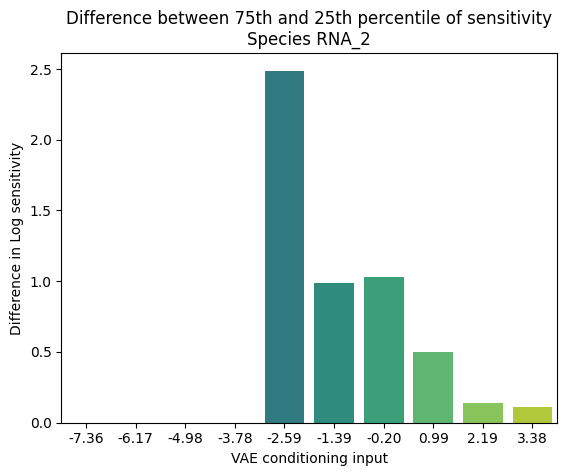

In [84]:
for k in config_dataset.objective_col:
    sns.barplot(pd.DataFrame((diffs_conditional_real_sens[..., -1] - diffs_conditional_real_sens[..., 0])[None, :], columns=[
                f'{ii:.2f}' for ii in sampled_conds.flatten()]), palette='viridis')
    txt = 'sensitivity' if 'sensitivity' in k else ('adaptation' if 'adaptation' in k else k)
    plt.title(f'Difference between 75th and 25th percentile of {txt}\nSpecies {config_dataset.output_species[0]}')
    plt.xlabel('VAE conditioning input')
    plt.ylabel(f'Difference in {k}')

Text(0.5, 0.98, 'Generated circuits: sensitivity vs. precision')

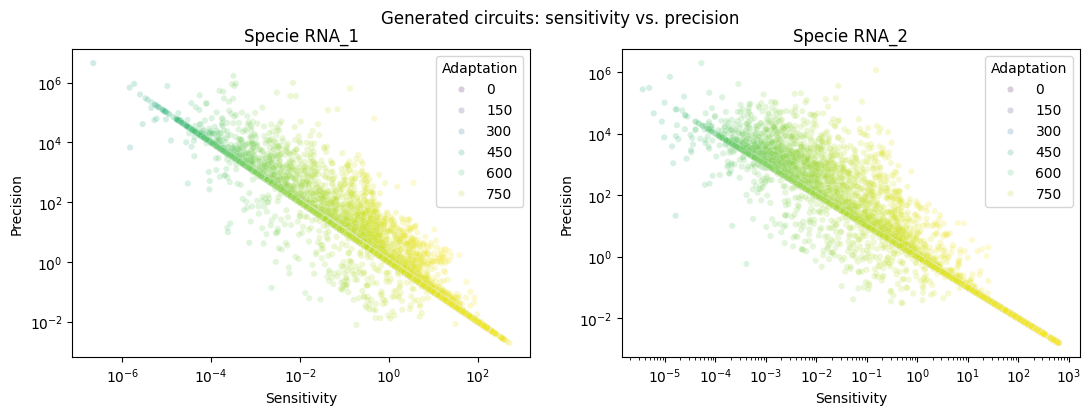

In [85]:
fig = plt.figure(figsize=(13, 4))

# category_array = np.array(sorted(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"].values())).repeat(
#     len(analytics['sensitivity_wrt_species-6'])//len(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"]))
# category_array = sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), -1)
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    d['VAE conditioning input'] = category_array
    ax = plt.subplot(1,2,i+1)
    sns.scatterplot(d, x='Sensitivity', y='Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Specie {output_specie}')
plt.suptitle('Generated circuits: sensitivity vs. precision')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

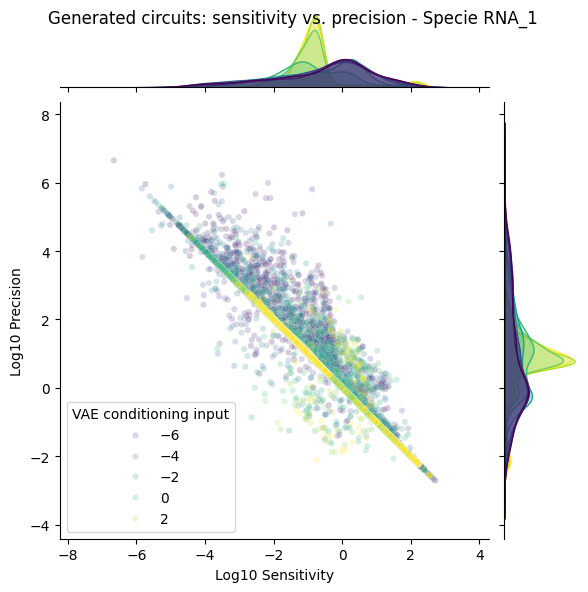

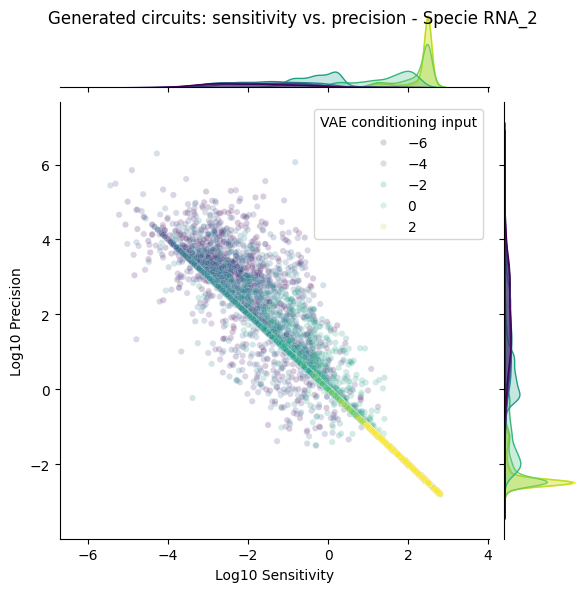

In [86]:
# fig = plt.figure(figsize=(13, 4))
plt.subplots_adjust(top=0.8)

for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    d['Log10 Sensitivity'] = np.log10(d['Sensitivity'])
    d['Log10 Precision'] = np.log10(d['Precision'])
    d['VAE conditioning input'] = category_array
    # ax = plt.subplot(1,2,i+1)
    # sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20)
    sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='VAE conditioning input', palette='viridis', s=20)
    # plt.title(f'Specie {output_specie}')
    plt.suptitle(f'Generated circuits: sensitivity vs. precision - Specie {output_specie}')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Model's best circuit

Is there a circuit generated by the model that's better than anything in the training data?

In [87]:
use_loaded = False

if use_loaded:
    # 2025_01_17__16_33_03
    # 2025_01_14__18_00_06
    # 2025_01_10__16_31_12
    analytics = load_json_as_dict(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'analytics.json'))
    fake_circuits = np.load(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'fake_circuits.npy'))
    ts = np.load(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'ts.npy'))
    sampled_cond = np.load(os.path.join('data/02_cvae_verify/2025_01_21__16_23_09', 'sampled_cond.npy'))
    for k in analytics.keys():
        analytics[k] = np.array(analytics[k])
    if 'Log sensitivity' not in analytics:
        analytics['Log sensitivity'] = np.log10(analytics['sensitivity_wrt_species-6'])
        analytics['Log precision'] = np.log10(analytics['precision_wrt_species-6'])
    analytics['adaptation'] = calculate_adaptation(
        analytics['sensitivity_wrt_species-6'], analytics['precision_wrt_species-6'])


In [88]:
df_analytics = pd.DataFrame({k: v.flatten() for k, v in analytics.items()})
df_analytics['sample_name'] = np.repeat(np.arange(9)[:, None], repeats=len(df_analytics)//9, axis=1).T.flatten()

In [89]:
output_idx = -1
print('Max s1\tMax s2\tMax a\tSens at max adapt')

output_training = {}
output_model = {}
for k in ['Max response time', 'Max log10 sensitivity', 'Max adaptation', 'Max sensitivity at max adaptation']:
    output_training.setdefault(k, [])
    output_model.setdefault(k, [])
for p in np.arange(0.1, 1.1, 0.01):
    filt = (np.abs(data['Log sensitivity']) < np.inf) & data['sample_name'].isin(
        ['RNA_2']) & (data['response_time_wrt_species-6'] < (p*ts.max()))
    filt2 = (df_analytics['response_time_wrt_species-6']
             < (p*ts.max())) & (df_analytics['sample_name'] == 8)
    # stats = (np.max(df_analytics[filt2]['Log sensitivity']),
    #       np.max(data[filt]['Log sensitivity']),
    #       np.max(data[filt]['adaptation']),
    #       data[filt & (data['adaptation'] == np.max(data[filt]['adaptation']))]['Log sensitivity'].iloc[0])
    # print(''.join([f'{s:.2f}\t' for s in stats]))
    
    output_training['Max response time'].append(p*ts.max())
    output_training['Max log10 sensitivity'].append(np.max(data[filt]['Log sensitivity']))
    output_training['Max adaptation'].append(np.max(data[filt]['adaptation']))
    output_training['Max sensitivity at max adaptation'].append(data[filt & (data['adaptation'] == np.max(data[filt]['adaptation']))]['Log sensitivity'].iloc[0])
    
    output_model['Max response time'].append(p*ts.max())
    output_model['Max log10 sensitivity'].append(np.max(df_analytics[filt2]['Log sensitivity']))
    output_model['Max adaptation'].append(np.max(df_analytics[filt2]['adaptation']))
    output_model['Max sensitivity at max adaptation'].append(df_analytics[filt2 & (df_analytics['adaptation'] == np.max(df_analytics[filt2]['adaptation']))]['Log sensitivity'].iloc[0])

Max s1	Max s2	Max a	Sens at max adapt


In [90]:
output_training = pd.DataFrame(output_training)
output_training['Source'] = 'Training data'
output_model = pd.DataFrame(output_model)
output_model['Source'] = 'Model generated'

df_maxes = pd.concat([output_training, output_model]).reset_index(drop=True)

Text(0.5, 1.0, 'Maximum adaptability for circuits within a response time')

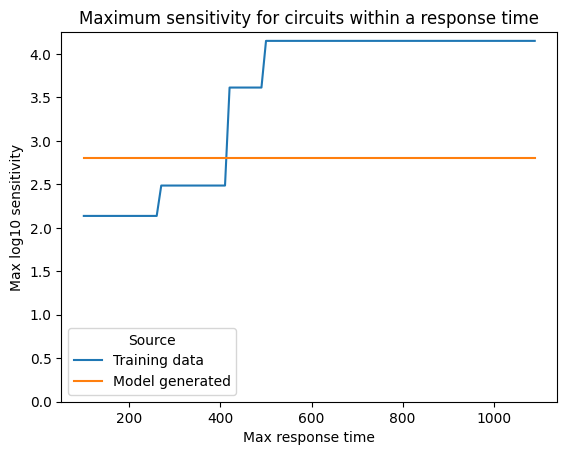

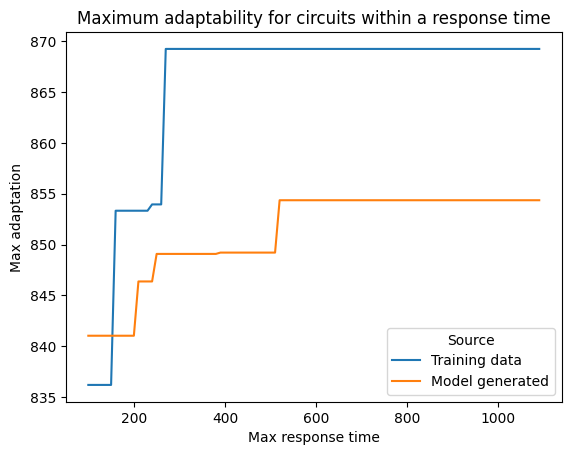

In [91]:
sns.lineplot(df_maxes, x='Max response time', y='Max log10 sensitivity', hue='Source')
plt.ylim(0, None)
plt.title('Maximum sensitivity for circuits within a response time')

plt.figure()
sns.lineplot(df_maxes, x='Max response time', y='Max adaptation', hue='Source')
plt.title('Maximum adaptability for circuits within a response time')

